In [1]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/neurad-studio

/home/s0001900/dev/neurad-studio


In [2]:
import typing
from typing import Optional
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionImg2ImgPipeline, UNet2DConditionModel
from diffusers.image_processor import VaeImageProcessor
import torch
from transformers import AutoTokenizer
from transformers import CLIPTextModel


from nerfstudio.generative.diffusion_model import DiffusionModelId
from nerfstudio.generative.diffusion_model import import_encoder_class_from_model_name_or_path

model_id = DiffusionModelId.sd_v2_1
revision: str = "main"
variant: Optional[str] = None 

device = torch.device("cuda")
dtype = torch.float16



In [30]:
img_processor = VaeImageProcessor()

noise_scheduler = typing.cast(DDPMScheduler, DDPMScheduler.from_pretrained(
    model_id, subfolder="scheduler"
))

unet = typing.cast(UNet2DConditionModel, 
                   UNet2DConditionModel.from_pretrained(
    model_id,
    subfolder="unet",
    revision=revision,
    variant=variant,

))

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
    revision=revision,
    use_fast=False,
)

text_encoder_cls = import_encoder_class_from_model_name_or_path(
    model_id, revision, subfolder="text_encoder"
)

text_encoder = typing.cast(CLIPTextModel, text_encoder_cls.from_pretrained(
    model_id,
    subfolder="text_encoder",
    revision=revision,
    variant=variant,
))

vae = typing.cast(AutoencoderKL, AutoencoderKL.from_pretrained(
    model_id,
    subfolder="vae",
    revision=revision,
    variant=variant,
))

models = {"img_processor": img_processor, "unet": unet, "tokenizer": tokenizer, "text_encoder": text_encoder, "vae": vae}

# TODO: Compile

vae.requires_grad_(False)
vae.to(device=device, dtype=dtype)

unet.requires_grad_(False)
unet.to(device=device, dtype=dtype)

text_encoder.requires_grad_(False)
text_encoder.to(device=device, dtype=dtype)

do_classifier_free_guidance: bool = True

#unet = torch.compile(unet)

...;

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


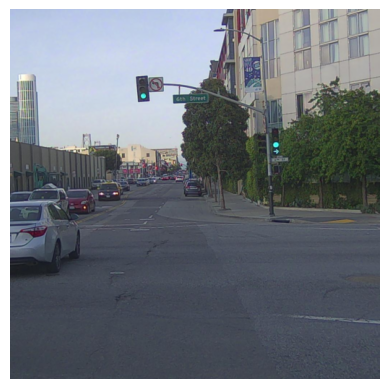

In [5]:
from pathlib import Path
from nerfstudio.generative.dynamic_dataset import make_img_tf_pipe, read_image
from nerfstudio.generative.utils import show_img


ex_img_path = Path("data/pandaset/001/camera/front_camera/00.jpg")
ex_img = read_image(ex_img_path, make_img_tf_pipe(dtype=dtype, crop_type="center"), device=device)
show_img(ex_img)

In [46]:
from nerfstudio.generative.diffusion_model import encode_img


latent = encode_img(img_processor, vae, ex_img, device)
latent.shape

torch.Size([1, 4, 64, 64])

In [62]:
num_inference_steps = 50
noise_scheduler.set_timesteps(num_inference_steps)
timesteps = noise_scheduler.timesteps
timesteps = noise_scheduler.timesteps

def get_timesteps(noise_scheduler, num_inference_steps, strength, device):
    # get the original timestep using init_timestep
    init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

    t_start = max(num_inference_steps - init_timestep, 0)
    timesteps = noise_scheduler.timesteps[t_start * noise_scheduler.order :]
    if hasattr(noise_scheduler, "set_begin_index"):
        noise_scheduler.set_begin_index(t_start * noise_scheduler.order)

    return timesteps, num_inference_steps - t_start

timesteps, num_inference_steps = get_timesteps(noise_scheduler, num_inference_steps, 0.2, device)
timesteps

tensor([181, 161, 141, 121, 101,  81,  61,  41,  21,   1])

In [57]:
from nerfstudio.generative.diffusion_model import get_ordered_timesteps


with torch.no_grad():
    timesteps = get_ordered_timesteps(0.2, device, num_timesteps=50)
    #timesteps[0] = 0


timesteps

tensor([  3,   7,   8,  13,  18,  20,  24,  30,  34,  37,  41,  46,  52,  56,
         60,  63,  68,  70,  75,  78,  84,  87,  90,  97,  99, 105, 108, 111,
        117, 120, 124, 127, 131, 137, 139, 145, 150, 154, 157, 161, 163, 170,
        173, 176, 183, 184, 191, 194, 196, 200], device='cuda:0')

In [63]:
from nerfstudio.generative.diffusion_model import add_noise_to_latent


noisy_latent = add_noise_to_latent(latent, timesteps[0], noise_scheduler)
noisy_latent.shape

torch.Size([1, 4, 64, 64])

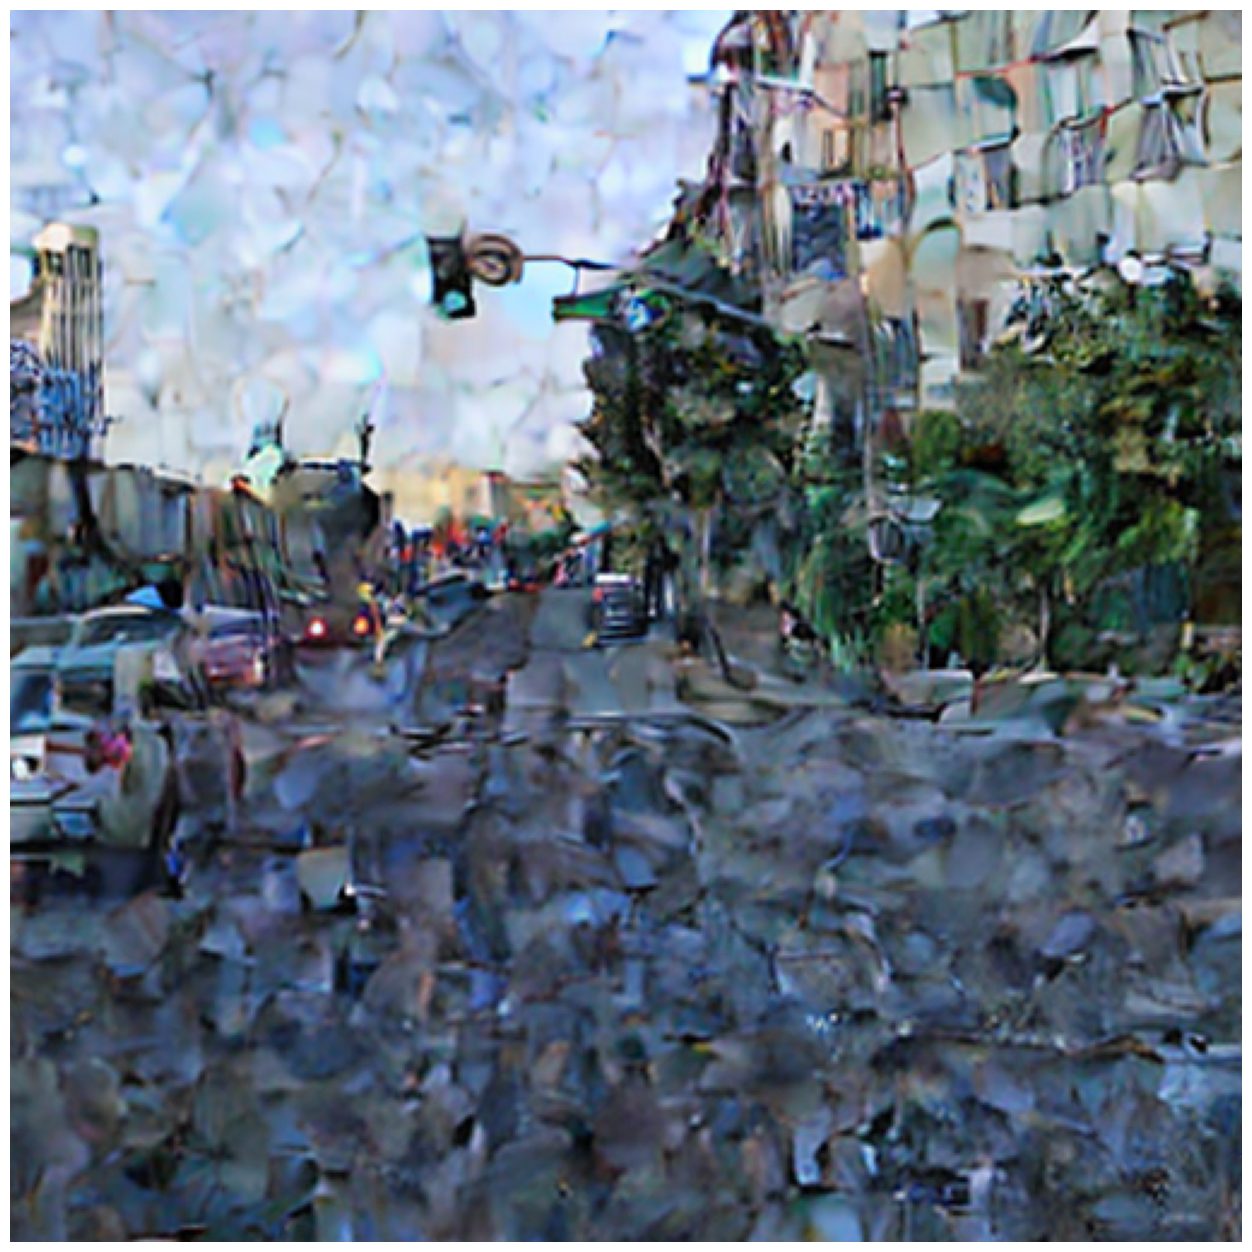

In [64]:
from nerfstudio.generative.diffusion_model import decode_img


with torch.no_grad():
    show_img(decode_img(img_processor, vae, noisy_latent))

In [65]:
from nerfstudio.generative.diffusion_model import embed_prompt


with torch.no_grad():
    prompt_embeds = embed_prompt(tokenizer, text_encoder, "")

if do_classifier_free_guidance:
    prompt_embeds = torch.cat((prompt_embeds, prompt_embeds))

prompt_embeds.shape

torch.Size([2, 77, 1024])

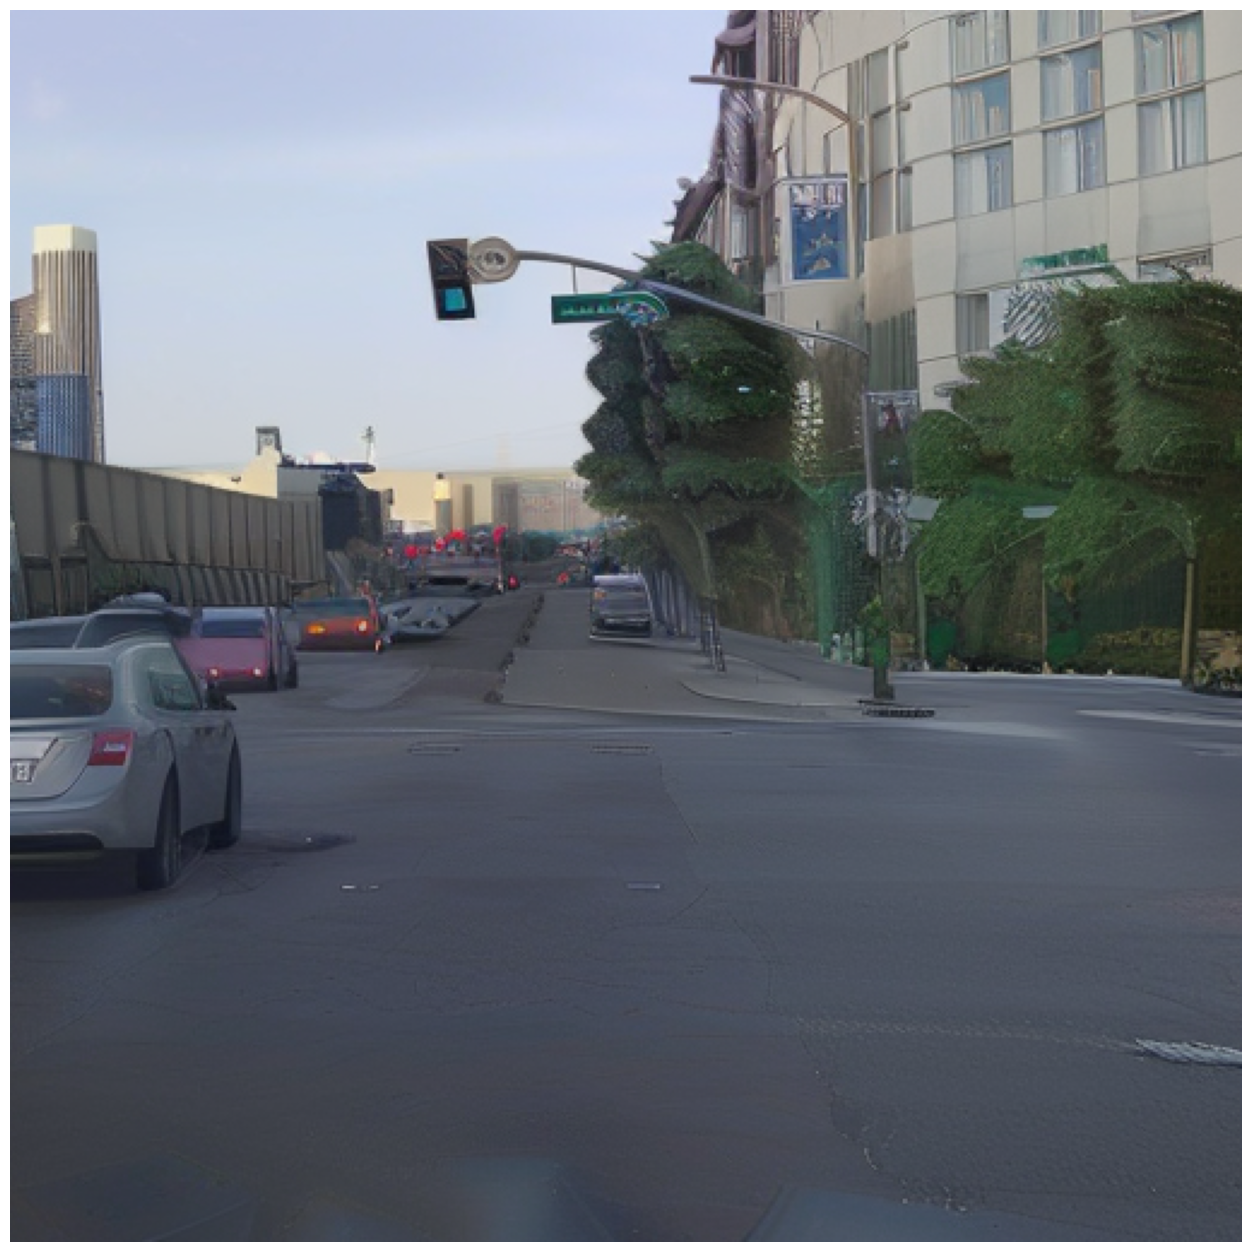

In [66]:
from nerfstudio.generative.diffusion_model import denoise_latent, get_ordered_timesteps
from nerfstudio.generative.diffusion_model import decode_img



with torch.no_grad():
    denoised_latent = denoise_latent(noisy_latent, unet, timesteps, noise_scheduler, prompt_embeds)
    denoised_img = decode_img(img_processor, vae, denoised_latent)
    show_img(denoised_img)

# StableDiffusionPipe

In [35]:
import torch
from nerfstudio.generative.diffusion_model import StableDiffusionModel, DiffusionModelConfig

device = torch.device("cuda")


config = DiffusionModelConfig(
    model_id = DiffusionModelId.sd_v2_1,
    dtype="fp16",
    noise_strength=0.2,
    num_inference_steps=50,
)
sd_model = StableDiffusionModel(config, device=device)

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


RuntimeError: NVML_SUCCESS == DriverAPI::get()->nvmlInit_v2_() INTERNAL ASSERT FAILED at "../c10/cuda/CUDACachingAllocator.cpp":1123, please report a bug to PyTorch. 

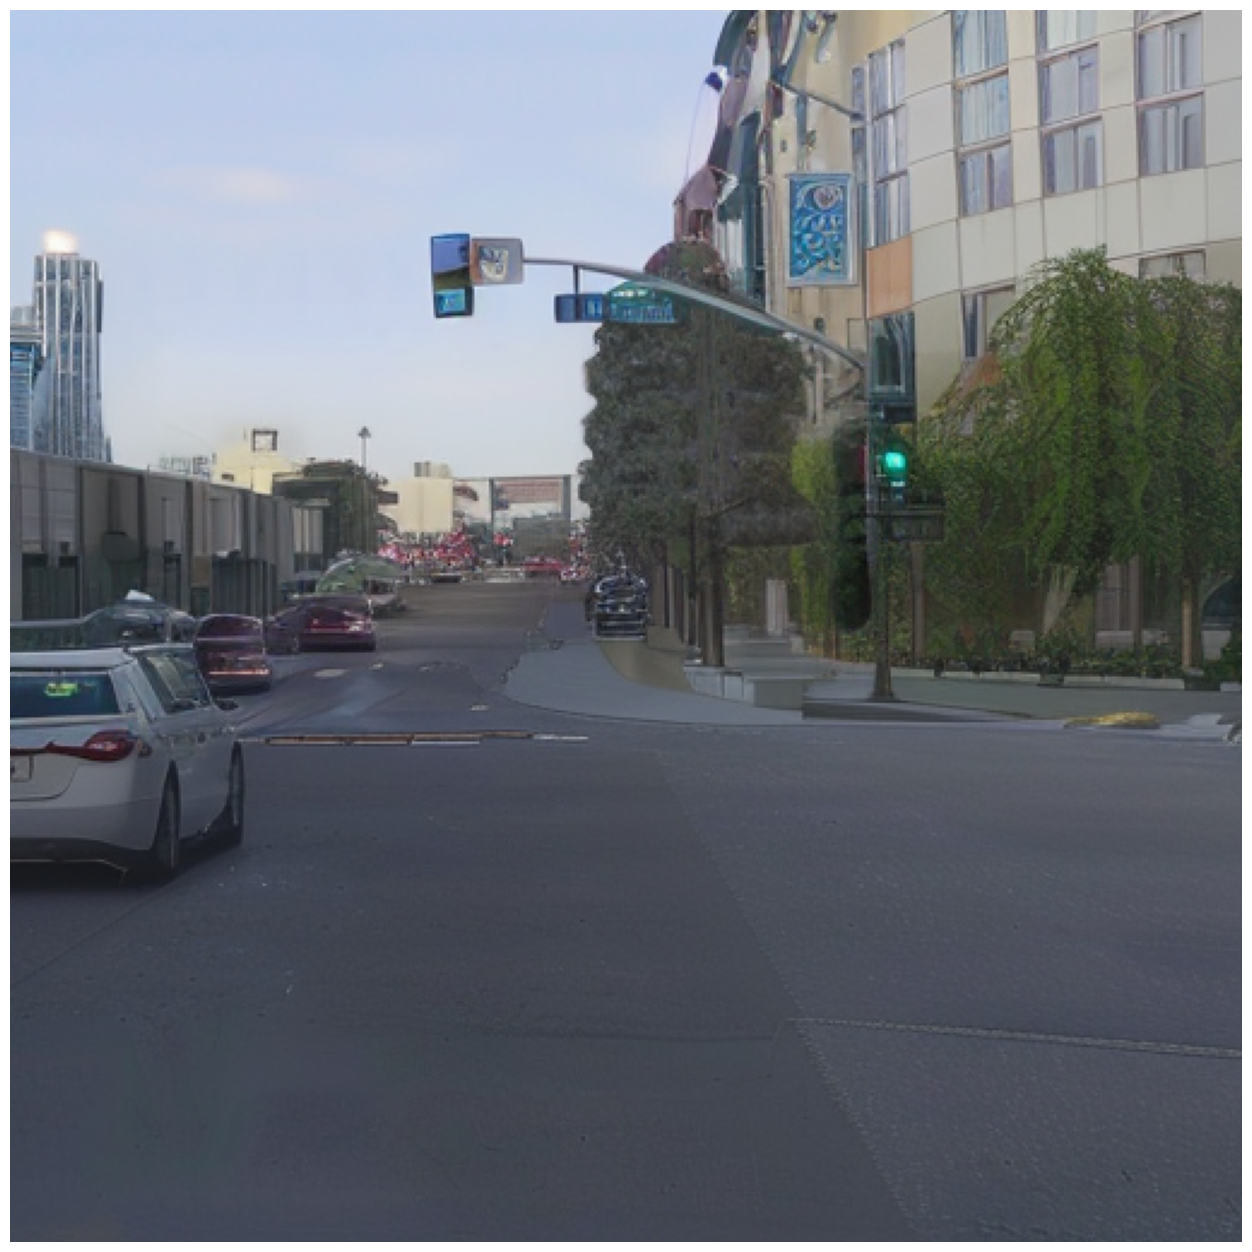

In [34]:
sd_out = sd_model.get_diffusion_output(
    {"rgb": ex_img[None, ...]}
)
show_img(sd_out["rgb"])

# HuggingFace pipeline

In [31]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id, vae=vae, text_encoder=text_encoder, unet=unet, scheduler=noise_scheduler, safety_checker=None
)
pipe.to(device=device, dtype=dtype)


...;

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

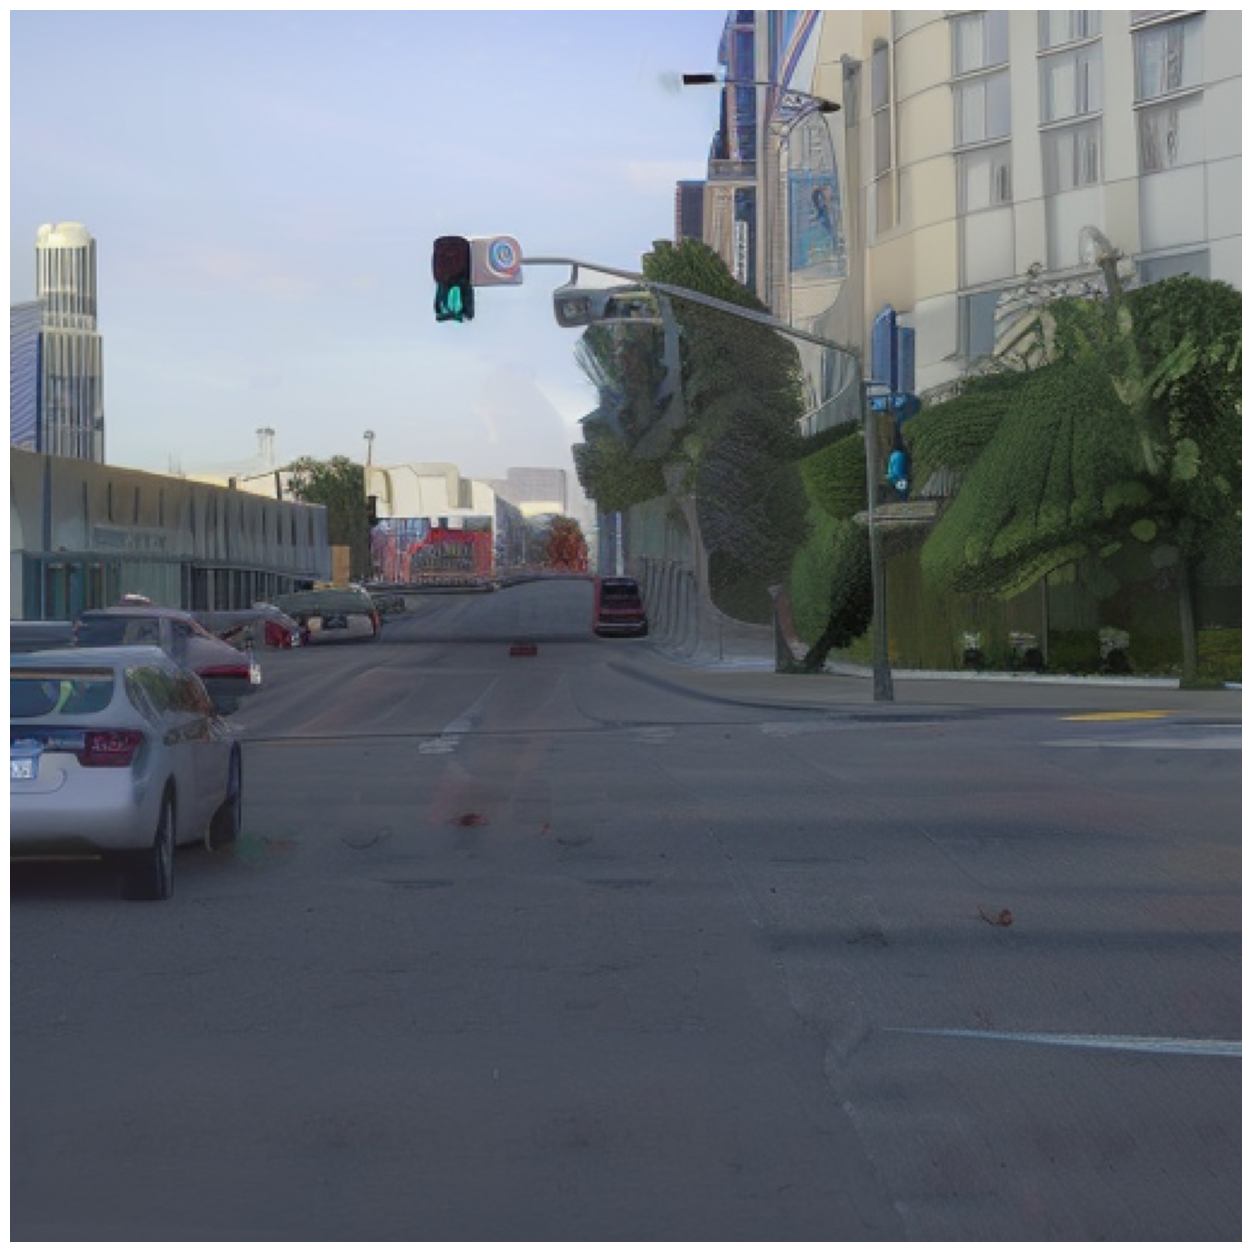

In [33]:
img_out = pipe(image=ex_img, prompt="", strength=0.2, num_inference_steps=50, output_type="pt").images
show_img(img_out)

# Lora

In [ ]:
from nerfstudio.generative.diffusion_model import parse_target_ranks

from peft import LoraConfig, get_peft_model, get_peft_model_state_dict


unet_target_ranks = {
    "downblocks": {"attn": 4, "resnet": 4, "ff": 8, "proj": 8},
    "midblocks": {"attn": 8, "resnet": 8, "ff": 16, "proj": 16},
    "upblocks": {"attn": 8, "resnet": 8, "ff": 16, "proj": 16},
}
unet_ranks = parse_target_ranks(unet_target_ranks)
unet_peft_conf = LoraConfig(
    r=8,
    lora_alpha=8,
    init_lora_weights="gaussian",
    target_modules="|".join(unet_ranks.keys()),
    rank_pattern=unet_ranks,
    use_dora=True,
)



In [ ]:
from copy import deepcopy


unet_copy = deepcopy(unet)
unet_copy

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Linear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_f

In [ ]:
peft_unet = get_peft_model(unet_copy, unet_peft_conf, "lora_A")
peft_unet

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): lora.Linear(
                (base_layer): Linear(in_features=320, out_features=320, bias=True)
                (lora_dropout): ModuleDict(
                  (lora_A): Identity()
                )
                (lora_A): ModuleDict(
                  (lora_A): Linear(in_features=320, out_features=8, bias=False)
                )
                (lora

In [ ]:
peft_unet.add_adapter("lora_B", unet_peft_conf)
peft_unet

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): lora.Linear(
                (base_layer): Linear(in_features=320, out_features=320, bias=True)
                (lora_dropout): ModuleDict(
                  (lora_A): Identity()
                  (lora_B): Identity()
                )
                (lora_A): ModuleDict(
                  (lora_A): Linear(in_features=320, out_features=8, bias=False)


In [ ]:
# This is how we're going to make ControlNet work. One adapter for LoRA, one adapter for controlnet!
peft_unet.base_model.set_adapter(["lora_A", "lora_B"])
peft_unet.active_adapters

['lora_A', 'lora_B']

In [ ]:
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Linear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_f

In [ ]:
peft_unet.print_trainable_parameters()

trainable params: 14,197,120 || all params: 880,107,844 || trainable%: 1.6131


In [ ]:
peft_unet.save_pretrained("tmp/peft-model")

In [ ]:
from peft import PeftModel

unet_copy_2 = deepcopy(unet)


In [ ]:
peft_unet_2 = PeftModel.from_pretrained(unet_copy_2, "tmp/peft-model")

In [ ]:
from nerfstudio.generative.utils import modules_equal


modules_equal(peft_unet, peft_unet_2)

False